# Entrega 5
### Ignacio Ziccardi
### Genere al menos 3 situaciones que demuestren el efecto del alias cuando no se usa correctamente el filtro pasabajo de desambiguación o anti-alias.

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  7 10:17:33 2025

@author: nachi
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#%%  Valores de parámetros
Fo = 1.0
Fs = 1000.0 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras
ts = 1/Fs # tiempo de muestreo
df = Fs/N # resolución espectral
Ac =2**0.5 #Amplitud 
DC = 0 #Valor Contínua
tita = 0 #Defasaje
#SNR = 20 # SNR en dB
#sigma = (10**(-SNR/10)) #Varianza
#desvio = sigma**0.5 #Desvío Estándar
B = 8 #Número de Bits
fc = 0.8 #Factor de Carga para no tener saturación del ADC por ruido en el pico de la señal
Vref = 2#Ac/fc #Tensión de referencia del ADC
kn=1.0#Relación de potencias de Ruido Pn = kn * Pq
q = Vref/(2**(B-1))
Pq = (q**2)/12
sigma = kn*Pq#(10**(-SNR/10)) #Varianza
desvio = sigma**0.5 #Desvío Estándar
rat_oversampling = 8 #Este sería el k0
N_os = N * rat_oversampling

In [10]:
#%% Funciones
def my_sin_gen( vmax, dc, fo, ph, nn, fs): 
    tt = np.arange(0,nn*1/fs,1/fs) # grilla de sampleo temporal
    xx = vmax*np.sin(2*np.pi*fo*tt + ph) + dc #Senoidal
    return [tt, xx]

def cuantizar(signal, bits, vref):
    q = vref/(2**(bits-1)) 
    #s1 = (fc*Vref/Ac)*signal
    sq = signal*(1/q)
    sq1 = np.round(sq)
    ss_cuantizada = sq1*q#*(1/(fc*Vref/Ac))
    return ss_cuantizada

### Primero se genera una señal sinusoidal sobremuestreada, se la cuantizará y luego se la diezmará. En este ejemplo el diezmado y el sobremuestreo son iguales, si D > Oversampling el Aliasing que se puede producir será muy importante

In [17]:
#%%Obtengo señal con ruido y su versión cuantizada 
plt.close('all')

tt_os, s = my_sin_gen(vmax = Ac, dc = DC, fo = Fo, ph=tita, nn = N_os, fs =rat_oversampling * Fs )
#Genero señal aleatoria para el ruido
na=np.random.normal(0, desvio, N_os)

ss = s + na

ssq = cuantizar(signal = ss,bits = B,vref = Vref)#8Bits

Xq = ssq - ss

ssq2=ssq[::rat_oversampling]
tt2=tt_os[::rat_oversampling]

#bfrec = ff_os <= fs/2

#ss: Señal Analógica con Ruido Oversampleada
#ssq: Señal Cuantizada Oversampleada
#ssq2: Señal Diezmada

#El Diezmado y el Oversampling son iguales, si el D > Ov se producirá un Aliasing muy importante

### Ahora procederemos a mostrar el espectro de la señales diezmada y sobremuestreada (sin aplicar ningún filtro)

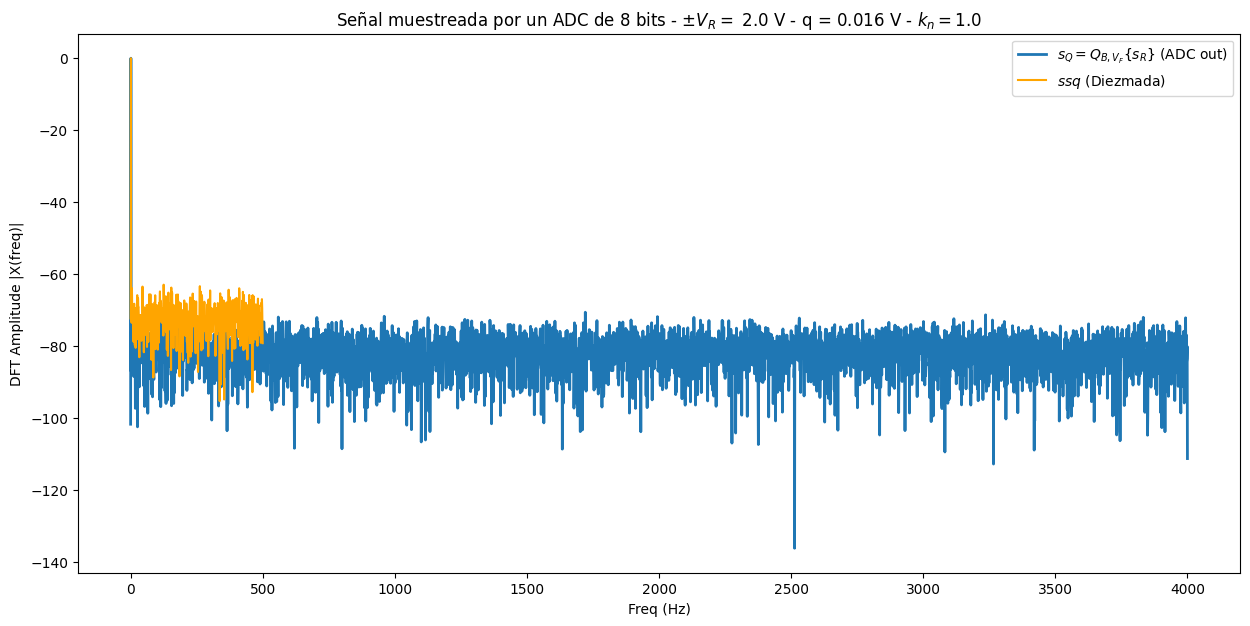

In [12]:
#%%Ploteo Espectros
ff_os = np.arange(0,rat_oversampling*Fs,df) # grilla de frecuencia
bfrec_os = ff_os <= rat_oversampling*Fs/2
ff = np.arange(0,Fs,df) # grilla de frecuencia
bfrec = ff <= Fs/2

#Lo que Ingresa al ADC
TFF=np.fft.fft(ss)/len(ss)#Espectro de la señal que ingresa en el ADC
mod=10*np.log10(2*np.abs(TFF)**2)
#Señal Cuantizada
TFF1=np.fft.fft(ssq)/len(ssq)#Espectro de la señal cuantizada
mod1=10*np.log10(2*np.abs(TFF1)**2)
TFF2=np.fft.fft(ssq2)/len(ssq2)#Espectro de la señal diezmada
mod2=10*np.log10(2*np.abs(TFF2)**2)
'''
#Ruido Analógico
TFFean=np.fft.fft(na)/N#Espectro de la estimacion de ruido de cuantizacion
modea=10*np.log10(2*np.abs(TFFean)**2)
#Ruido de Cuantización
TFFq1=np.fft.fft(Xq1)/N#Espectro del ruido 4 Bits
modq1=10*np.log10(2*np.abs(TFFq1)**2)#10*np.log10(escala)

Nq = np.mean(np.abs(TFFq1**2))
NqdB=10*np.log10(2*Nq)#10*np.log10(escala)
ff = tt2*len(tt2)*df*2

Na = np.mean(np.abs(TFFean**2))
NadB=10*np.log10(2*Na)
'''
plt.figure("DFT Senoidal Cuantizada ",figsize=(15, 7))
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V - $k_n = {:3.1f}$'.format(B, Vref, q,kn) )
plt.plot(ff_os[bfrec_os], mod1[bfrec_os],lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(ff[bfrec], mod2[bfrec], color='orange', label='$ ssq $ (Diezmada)')
plt.xlabel("Freq (Hz)")
plt.ylabel("DFT Amplitude |X(freq)|")
plt.legend()
plt.show()

### En este caso se observa claramente que la señal diezmada tiene otro nivel de ruido ya que está por encima de la señal sobremuestreada. Esto se debe al Aliasing que se produce dado que al diezmar también se achica la fecuencia de sampling. Ahora se verán los casos con un filtro bien diseñado y que ocurre cuando el filtro no se diseña adecuadamente.

In [18]:
#%%Diseño del filtro y Aplicación correcta e incorrecta del mismo

# FIR Tipo 2 fuerzo filter_size par
antisymmetric = False
cte_filtro=0.05
ftran = 0.1#Transición del 10%, en caso de reducirlo se exige mucho al filtro
fstop = 1/rat_oversampling + ftran/2 # Si sumo constantes a las fstop y fpass cambia el nivel de ruido, al mover fpass y stop a la "derecha" se produce Aliasing en la sercanía de Nyquist y caso contrario disminuyo en exceso la relación de señal ruido

fpass = 1/rat_oversampling - ftran/2 # 
ripple = 0.5 # dB
attenuation = 40 # dB
filter_type = 'lowpass'
aprox_name = 'butter'

# pasa bajo
frecs = [0.0,  fpass,     fstop,           1.0]
# la mitad de la att porque usaremos filtfilt
gains = [0,   -ripple/2, -attenuation/2,  -attenuation/2] # dB

gains = 10**(np.array(gains)/20)

orderz, wcutofz = sig.buttord( fpass, fstop, ripple, attenuation, analog=False)
orderz1, wcutofz1 = sig.buttord( fpass + cte_filtro, fstop + cte_filtro, ripple, attenuation, analog=False)
orderz2, wcutofz2 = sig.buttord( fpass - cte_filtro, fstop - cte_filtro, ripple, attenuation, analog=False)
#numz, denz = sig.iirfilter(orderz, wcutofz, rp=ripple, rs=attenuation, btype=filter_type, analog=False, ftype=aprox_name)

sos_filter = sig.iirfilter(orderz, wcutofz, rp=ripple, rs=attenuation, btype=filter_type, analog=False, ftype=aprox_name, output='sos')
sos_filter1 = sig.iirfilter(orderz1, wcutofz1, rp=ripple, rs=attenuation, btype=filter_type, analog=False, ftype=aprox_name, output='sos')
sos_filter2 = sig.iirfilter(orderz2, wcutofz2, rp=ripple, rs=attenuation, btype=filter_type, analog=False, ftype=aprox_name, output='sos')


ssq_filter = sig.sosfiltfilt(sos_filter, ssq)
ssq2=ssq_filter[::rat_oversampling]
ssq_filter1 = sig.sosfiltfilt(sos_filter1, ssq)
ssq_filter2 = sig.sosfiltfilt(sos_filter2, ssq)
ssq3=ssq_filter1[::rat_oversampling]
ssq4=ssq_filter2[::rat_oversampling]

TFF3=np.fft.fft(ssq_filter)/len(ssq_filter)#Espectro de la señal cuantizada
mod3=10*np.log10(2*np.abs(TFF3)**2)
TFF2=np.fft.fft(ssq2)/len(ssq2)#Espectro de la señal diezmada
mod2=10*np.log10(2*np.abs(TFF2)**2)
TFF4=np.fft.fft(ssq3)/len(ssq3)#Espectro de la señal diezmada
mod4=10*np.log10(2*np.abs(TFF4)**2)
TFF5=np.fft.fft(ssq4)/len(ssq4)#Espectro de la señal diezmada
mod5=10*np.log10(2*np.abs(TFF5)**2)

## Se diseña el filtro para estudiar los siguientes 3 casos:
#### 1) Frecuencia de Stop en 1/Oversampling + una transición del 10% y Frecuencia de Paso en 1/Oversampling - una transición del 10% (Caso correcto)
#### 2) Frecuencia de Stop en 1/Oversampling + una transición del 10% + constante y Frecuencia de Paso en 1/Oversampling - una transición del 10% + constante. (Se mueve la plantilla del filtro ligeramente hacia la derecha)
#### 3) Frecuencia de Stop en 1/Oversampling + una transición del 10% - constante y Frecuencia de Paso en 1/Oversampling - una transición del 10% - constante. (Se mueve la plantilla del filtro ligeramente hacia la izquierda)

## Se espera que en el caso 1 funcione correctamente y ver 2 problemas distintos en los otros casos

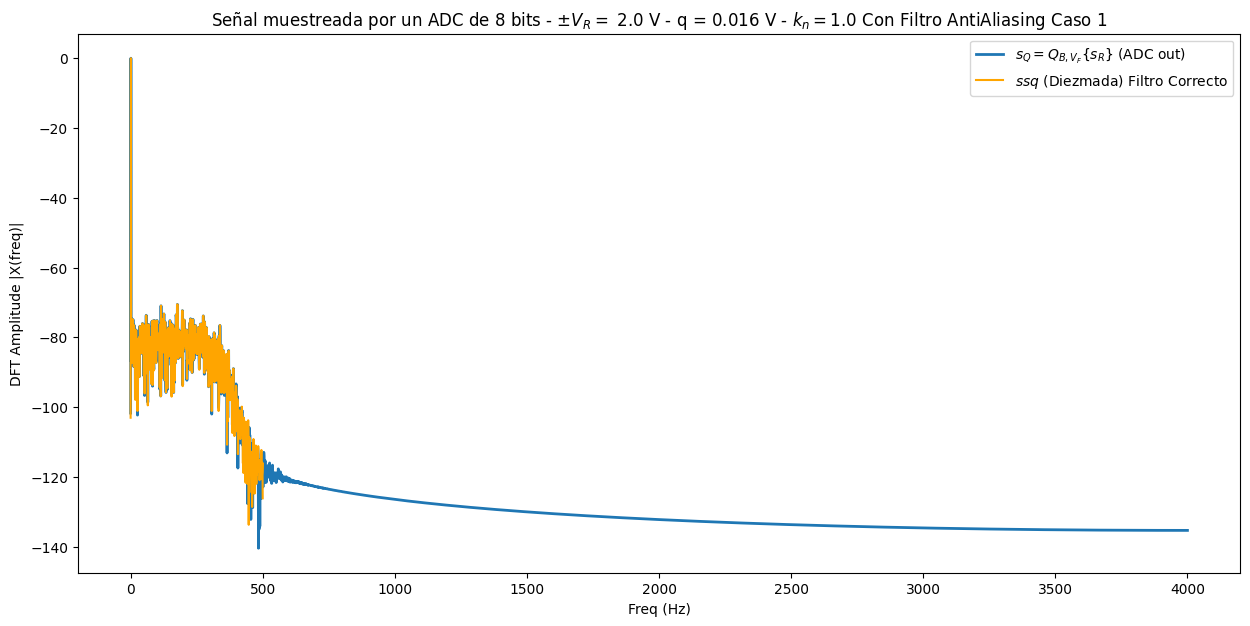

In [14]:
plt.figure("DFT Senoidal Cuantizada Con Filtro",figsize=(15, 7))
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V - $k_n = {:3.1f}$ Con Filtro AntiAliasing Caso 1'.format(B, Vref, q,kn) )
plt.plot(ff_os[bfrec_os], mod3[bfrec_os],lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(ff[bfrec], mod2[bfrec], color='orange', label='$ ssq $ (Diezmada) Filtro Correcto')
plt.xlabel("Freq (Hz)")
plt.ylabel("DFT Amplitude |X(freq)|")
plt.legend()
plt.show()

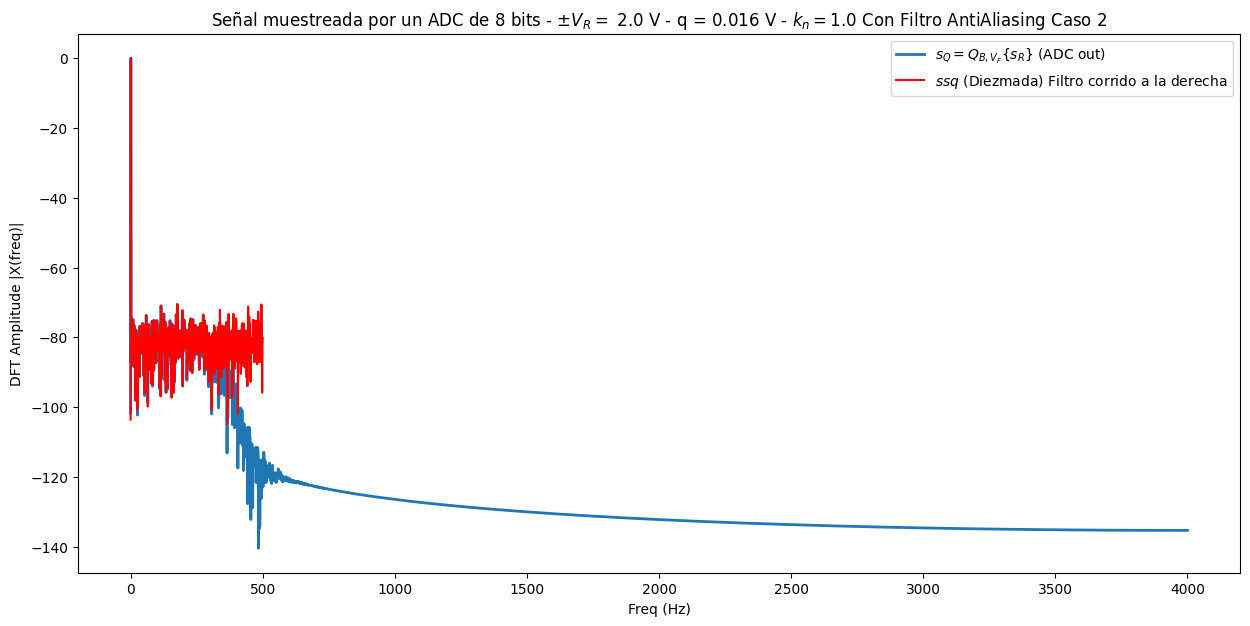

In [15]:
plt.figure("DFT Senoidal Cuantizada Con Filtro",figsize=(15, 7))
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V - $k_n = {:3.1f}$ Con Filtro AntiAliasing Caso 2'.format(B, Vref, q,kn) )
plt.plot(ff_os[bfrec_os], mod3[bfrec_os],lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(ff[bfrec], mod4[bfrec], color='red', label='$ ssq $ (Diezmada) Filtro corrido a la derecha')
plt.xlabel("Freq (Hz)")
plt.ylabel("DFT Amplitude |X(freq)|")
plt.legend()
plt.show()

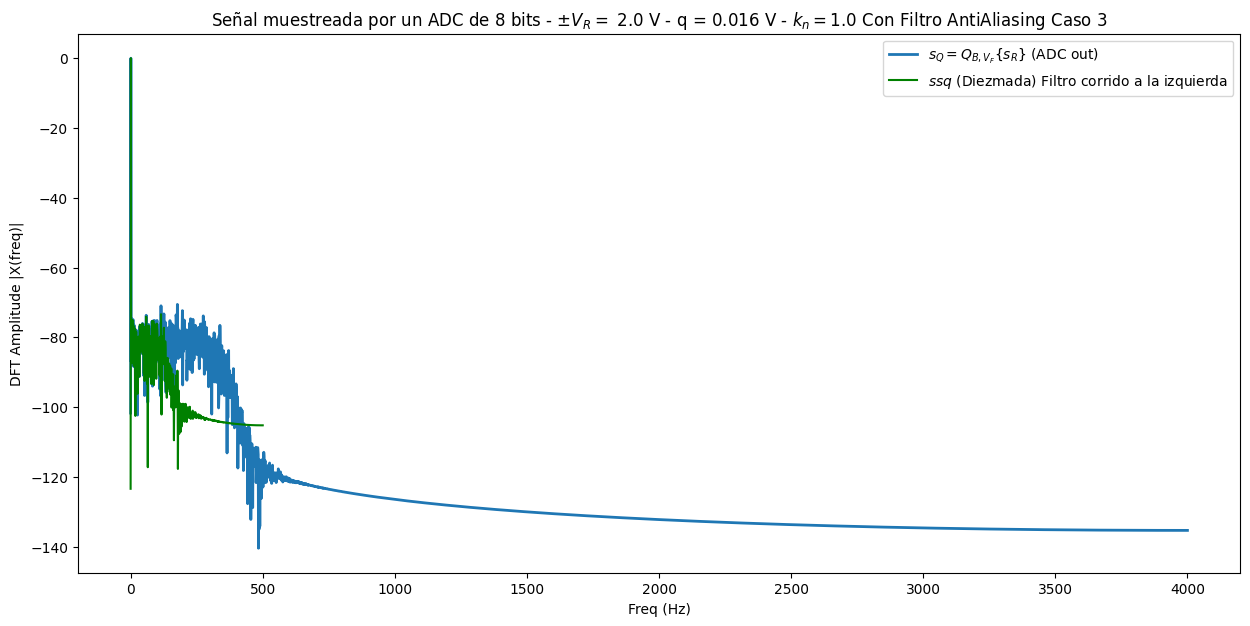

In [16]:
plt.figure("DFT Senoidal Cuantizada Con Filtro",figsize=(15, 7))
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V - $k_n = {:3.1f}$ Con Filtro AntiAliasing Caso 3'.format(B, Vref, q,kn) )
plt.plot(ff_os[bfrec_os], mod3[bfrec_os],lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\} $ (ADC out)')
plt.plot(ff[bfrec], mod5[bfrec], color='green', label='$ ssq $ (Diezmada) Filtro corrido a la izquierda')
plt.xlabel("Freq (Hz)")
plt.ylabel("DFT Amplitude |X(freq)|")
plt.legend()
plt.show()

# Conclusiones

El objetivo del filtro es evitar el efecto de alias en la señal diezmada. Si el filtro se usa correctamente se obtiene una señal diezmada que no compromete información de la señal original. Sin embargo, si el filtro se diseña de forma incorrecta se pueden presentar dos escenarios posibles:
1 - No se fue lo suficiente exigente con el filtro y se presenta alias en las cercanía de las frecuencias altas (cerca de Nyquist) por lo que el nivel de ruido cerca de la frecuencia de Nyquist es más alto de lo que debería.
2 - Se utilizó un filtro muy exigente y se perdió información en las frecuencias altas, se baja el nivel de ruido al mismo que la señal sobremuestreada pero se filtra parte de la misma en el proceso, generando que se pierda información.
En Conclusión, el filtro se debe utilizar correctamente de forma tal que no se pierda información y que al mismo tiempo no suba el nivel de ruido ni se produzca alias.